# Topic Detection

## Description
Perform topic detection.

## Setup

### Libraries (Pyhton)

In [1]:
from bertopic import BERTopic
import copy
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import community as community_louvain
import igraph as ig
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
import sys
from tqdm import tqdm

# For development only
from importlib import reload

### Directories

In [2]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'
RESULTS_MODELS_DIR = RESULTS_DIR / 'models'
RESULTS_MODELS_DIR.mkdir(exist_ok=True)

### Libraries (Custom)

In [3]:
import preprocess as prep
import topic as t

In [39]:
# For development only
reload(t)

<module 'topic' from 'C:\\Backup\\000_DS\\courses\\00-network-science\\ns-project\\src\\topic.py'>

## Import Data

In [4]:
# Graph
filename = RESULTS_GRAPHS_DIR / 'g_dd.graphml'
g_dd_nx = nx.read_graphml(str(filename))
g_dd = ig.Graph.from_networkx(g_dd_nx)

print(g_dd.summary())

IGRAPH UNW- 15819 924974 -- 
+ attr: edge_default (g), node_default (g), _nx_name (v), name (v), weight (e)


In [4]:
# Original documents
filename_df = DATA_DIR / 'docs_dd_giant.json'
df_dd = pd.read_json(str(filename_df), lines=True)

In [ ]:
# Check basic stats
print("--- Document-Projected Network (Giant Component) ---")
print(f"Size: {g_dd.vcount()}")
print(f"Average degree: {np.mean(g_dd.degree()):.2f}")
print(f"Median degree: {np.median(g_dd.degree()):.2f}")
print(f"Density: {g_dd.density():.5f}")
print(f"Diameter: {g_dd.diameter(directed=False, unconn=False):.2f}")
print(f"Average path length: {g_dd.average_path_length():.5f}")

--- Document-Projected Network (Giant Component) ---
Size: 15819
Average degree: 116.94
Median degree: 50.00
Density: 0.00739
Diameter: 6.00
Average path length: 2.51146


### Retrieve Original Text [NO NEED TO RUN]
Retrieve the original non-processed text from the documents in the network (giant component of Pdd).

In [ ]:
# --- Prep posts ---
filename_posts = POSTS_FILTERED_CLEAN_DIR / 'all_posts_clean.json'
df_posts = pd.read_json(str(filename_posts))

# Concantenate original test into a single column
df_posts["og_text"] = df_posts["title"].fillna('') + " " + df_posts["selftext"].fillna('')

# Rename document ID column
df_posts.rename(columns={"id": "document_id"}, inplace=True)

In [ ]:
# --- Prep comments ---
filename_comments = COMMENTS_CLEAN_DIR / 'all_comments_clean.json'
df_comments = pd.read_json(str(filename_comments))

# Rename comment_body column and comment_id column for compatibility with posts
df_comments.rename(columns={"comment_body": "og_text"}, inplace=True)
df_comments.rename(columns={"comment_id": "document_id"}, inplace=True)

In [ ]:
# Extract common columns and concatenate dfs
common_cols = df_posts.columns.intersection(df_comments.columns)
print(f"Common columns: {common_cols}")

df_merged = pd.concat([df_posts[common_cols], df_comments[common_cols]], ignore_index=True)

Common columns: Index(['subreddit', 'document_id', 'filtered_pos', 'og_text'], dtype='object')


In [ ]:
# Extract document IDs and filter by them
giant_dd_idx = g_dd.vs['name']
docs_in_giant_dd = df_merged.loc[giant_dd_idx, "document_id"]
filtered_df = df_merged[df_merged["document_id"].isin(docs_in_giant_dd)]

In [ ]:
# Save to JSON
# df_merged.to_json(DATA_DIR / 'docs_dd.json', orient='records', lines=True)
# filtered_df.to_json(DATA_DIR / 'docs_dd_giant.json', orient='records', lines=True)

### Prep Documents

In [5]:
# Preprocess documents
tqdm.pandas()
df_dd['clean_text'] = df_dd['og_text'].progress_apply(prep.bert_preprocess)
documents = list(df_dd['clean_text'])

100%|██████████| 15819/15819 [00:13<00:00, 1181.98it/s]


## BERTopic
Run BERTopic on the Pdd giant component.

### Fit Model

#### Original

In [ ]:
# Model parameters
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# bert_model = BERTopic(embedding_model=sentence_model, min_topic_size=50, nr_topics='auto')

In [ ]:
# Model fit
# topics, probabilities = bert_model.fit_transform(documents)

#### Reduce Outliers

In [ ]:
# reduced_model = copy.deepcopy(bert_model)
# reduced_topics = reduced_model.reduce_outliers(
    # documents,
    # reduced_model.topics_)

# reduced_model.update_topics(docs=documents, topics=reduced_topics)

2025-06-06 11:12:28,085 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


#### Save Models

##### Original

In [ ]:
# Save original model
# filepath_bert = RESULTS_MODELS_DIR / 'bert'
# embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
# bert_model.save(str(filepath_bert), serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)


##### Reduced

In [ ]:
# Save reduce outliers model
# filepath_bert_reduced = RESULTS_MODELS_DIR / 'bert_reduced'
# embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
# reduced_model.save(str(filepath_bert_reduced), serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

#### Load Models

##### Original

In [6]:
# Load model
filepath_bert = RESULTS_MODELS_DIR / 'bert'
bert_model = BERTopic.load(str(filepath_bert))

# Load topics
topics = bert_model.topics_
topics = np.array(topics)
df_dd["bertopic_topic"] = topics

# Load embeddings
filename_bert_embeddings = RESULTS_MODELS_DIR / 'bert' / 'docs_embeddings.npy'
embeddings = np.load(filename_bert_embeddings)
bert_model.embeddings_ = embeddings

##### Reduced

In [33]:
# Load model
filepath_bert_reduced = RESULTS_MODELS_DIR / 'bert_reduced'
reduced_model = BERTopic.load(str(filepath_bert_reduced))

# Load topics
topics_reduced = reduced_model.topics_
topics_reduced = np.array(topics)
df_dd["bertopic_topic_reduced"] = topics_reduced

# Load embeddings
filename_bert_reduced_embeddings = RESULTS_MODELS_DIR / 'bert_reduced' / 'docs_embeddings.npy'
embeddings_reduced = np.load(filename_bert_reduced_embeddings)
reduced_model.embeddings_ = embeddings_reduced

### Topic Interpretation (Original)

In [31]:
# Topic info
bert_model.get_topic_info()

Topic  Count                                   Name  \
0      -1   8835             -1_trans_people_like_would   
1       0    723   0_thank_thanks_happy_congratulations   
2       1    697                  1_cis_men_trans_women   
3       2    625     2_estrogen_hrt_growth_progesterone   
4       3    620     3_democrats_vote_republicans_party   
5       4    398       4_christians_christian_god_jesus   
6       5    334               5_state_states_blue_safe   
7       6    318                6_wear_dress_cold_pants   
8       7    308            7_life_transition_feel_time   
9       8    282                8_parents_mom_dad_child   
10      9    226        9_people_trans_hate_transphobic   
11     10    225         10_japanese_name_white_culture   
12     11    225      11_puberty_blockers_kids_children   
13     12    167       12_like_friend_relationship_talk   
14     13    144           13_neutral_guys_bro_gendered   
15     14    136  14_disney_characters_character_better   
16     15    132         15_name_marker_passport_change   
17     16    131          16_genocide_jews_nazis_hitler   
18     17    113             17_porn_blahaj_plushie_toy   
19     18    101            18_animals_sex_species_fish   
20     19     97         19_money_small_power_streaming   
21     20     91                 20_hair_body_women_cis   
22     21     86            21_bathroom_room_womens_use   
23     22     83     22_twitter_facebook_bluesky_reddit   
24     23     81            23_police_assault_call_cops   
25     24     80   24_fascist_fascists_fascism_liberals   
26     25     79                25_horny_orgasm_hrt_sex   
27     26     78       26_court_supreme_scotus_justices   
28     27     78           27_people_trans_us_community   
29     28     76               28_name_mom_names_mother   
30     29     74          29_surgery_doctor_top_medical   
31     30     60          30_rights_sarah_civil_freedom   
32     31     60         31_pronouns_theythem_itits_use   
33     32     56     32_federal_care_funding_healthcare   

                                       Representation  Representative_Docs  
0   [trans, people, like, would, us, get, know, th...                  NaN  
1   [thank, thanks, happy, congratulations, post, ...                  NaN  
2   [cis, men, trans, women, woman, like, man, peo...                  NaN  
3   [estrogen, hrt, growth, progesterone, months, ...                  NaN  
4   [democrats, vote, republicans, party, biden, d...                  NaN  
5   [christians, christian, god, jesus, bible, rel...                  NaN  
6   [state, states, blue, safe, red, california, l...                  NaN  
7   [wear, dress, cold, pants, funeral, wearing, g...                  NaN  
8   [life, transition, feel, time, like, things, y...                  NaN  
9   [parents, mom, dad, child, family, sorry, love...                  NaN  
10  [people, trans, hate, transphobic, transphobia...                  NaN  
11  [japanese, name, white, culture, racism, cultu...                  NaN  
12  [puberty, blockers, kids, children, child, tra...                  NaN  
13  [like, friend, relationship, talk, tell, want,...                  NaN  
14  [neutral, guys, bro, gendered, gender, sis, co...                  NaN  
15  [disney, characters, character, better, subjec...                  NaN  
16  [name, marker, passport, change, birth, certif...                  NaN  
17  [genocide, jews, nazis, hitler, holocaust, jew...                  NaN  
18  [porn, blahaj, plushie, toy, seen, trans, sexu...                  NaN  
19  [animals, sex, species, fish, humans, male, ge...                  NaN  
20  [money, small, power, streaming, selfish, alli...                  NaN  
21  [hair, body, women, cis, laser, hairs, hairy, ...                  NaN  
22  [bathroom, room, womens, use, restroom, locker...                  NaN  
23  [twitter, facebook, bluesky, reddit, account, ...                  NaN  
24  [police, 

#### Representative Documents

In [ ]:
# Get representative documents indices for each topic
repr_docs_idx_bert = t.get_representative_topics(10, bert_model, df_dd, 'clean_text', 'bertopic_topic', 'repr_doc_rank')

# Get top documents per topic (original non-preprocessed text)
repr_docs_text_bert = t.top_docs_per_topic(10, df_dd, 'og_text', 'bertopic_topic', 'repr_doc_rank')

#### Fine-tune with GPT [NO NEED TO RUN]

In [10]:
# Prepare dictionary for fine-tuned labels
topic_labels = {i: {} for i in range(33)}

Prompt ChatGPT (each topic requires a new chat) with:

Based on the following documents from the same topic, generate:
    1. A concise topic label (3–6 words).
    2. A short summary (1–2 sentences) describing the topic's content.

"Documnt 1: ... "
"Document 2: ... "
"Document 3: ... "
"Document 4: ... "
"Document 5: ... "
"Document ... "

In [ ]:
# Print top documents in a topic
topic_number = 32
t.print_top_docs(topic_number, repr_docs_text_bert)

In [ ]:
# Update topics with fine-tuned labels and summaries
topic_labels[topic_number]['gpt_label'] = "Federal Funding and Gender Affirming Care"
topic_labels[topic_number]['gpt_summary'] = "These documents discuss potential and proposed federal legislative actions aiming to restrict or ban the use of federal funds for gender affirming care, especially impacting Medicaid and Medicare recipients, and the broader implications for access to care across states and insurance types. The conversation covers legal, political, and practical challenges surrounding these restrictions, contrasting partial defunding with complete bans and highlighting ongoing uncertainties and grassroots responses."

# Check correctness
print(f"Topic: {topic_number}")
topic_labels[topic_number]

##### Save Custom Topics

In [ ]:
# Save to JSON
# sorted_data = {k: topic_labels[k] for k in sorted(topic_labels, key=int)}
# filename_bert_tuned_topics = RESULTS_MODELS_DIR / 'bert' / 'fine_tuned_topics_sorted.json'
# with open(filename_bert_tuned_topics, 'w') as file:
    # json.dump(sorted_data, file, indent=4)

##### Load Custom Topics

In [ ]:
# Load JSON
filename_bert_tuned_topics = RESULTS_MODELS_DIR / 'bert' / 'fine_tuned_topics_sorted.json'
with open(filename_bert_tuned_topics, 'r') as f:
    data = json.load(f)

topic_labels = {int(k): v for k, v in data.items()}

# Get topic ID - GPT label mapping and assign as model.custom_labels_
topic_labels_dict = {i: topic_labels[i]['gpt_label'] for i in range(-1, 33)}
bert_model.set_topic_labels(topic_labels_dict)

### Visualize Topics

In [124]:
bert_model.visualize_barchart(top_n_topics=32, title='BERTopic Word Scores', custom_labels=True, width=450, height=220, autoscale=True)

In [130]:
bert_model.visualize_documents(documents, custom_labels=True)

In [ ]:
# Extract community assignments
num_docs, num_topics, C = t.extract_community_assignments(bert_model.topics_, topic_ids_start=1)

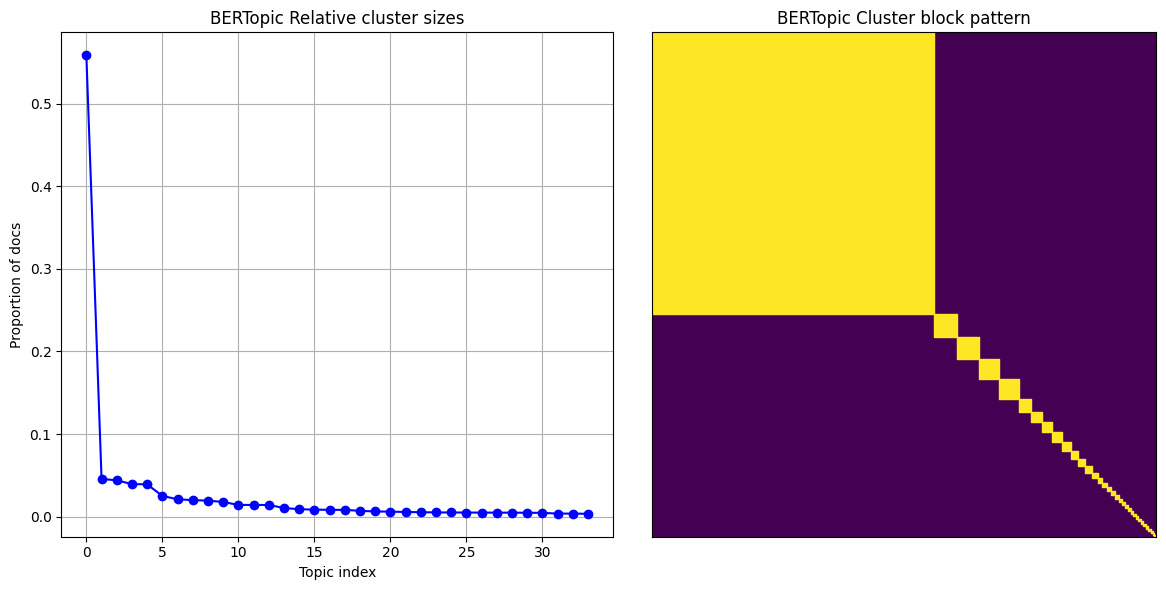

In [ ]:
# Plot CtC
t.plot_topic_pattern(num_docs, C)

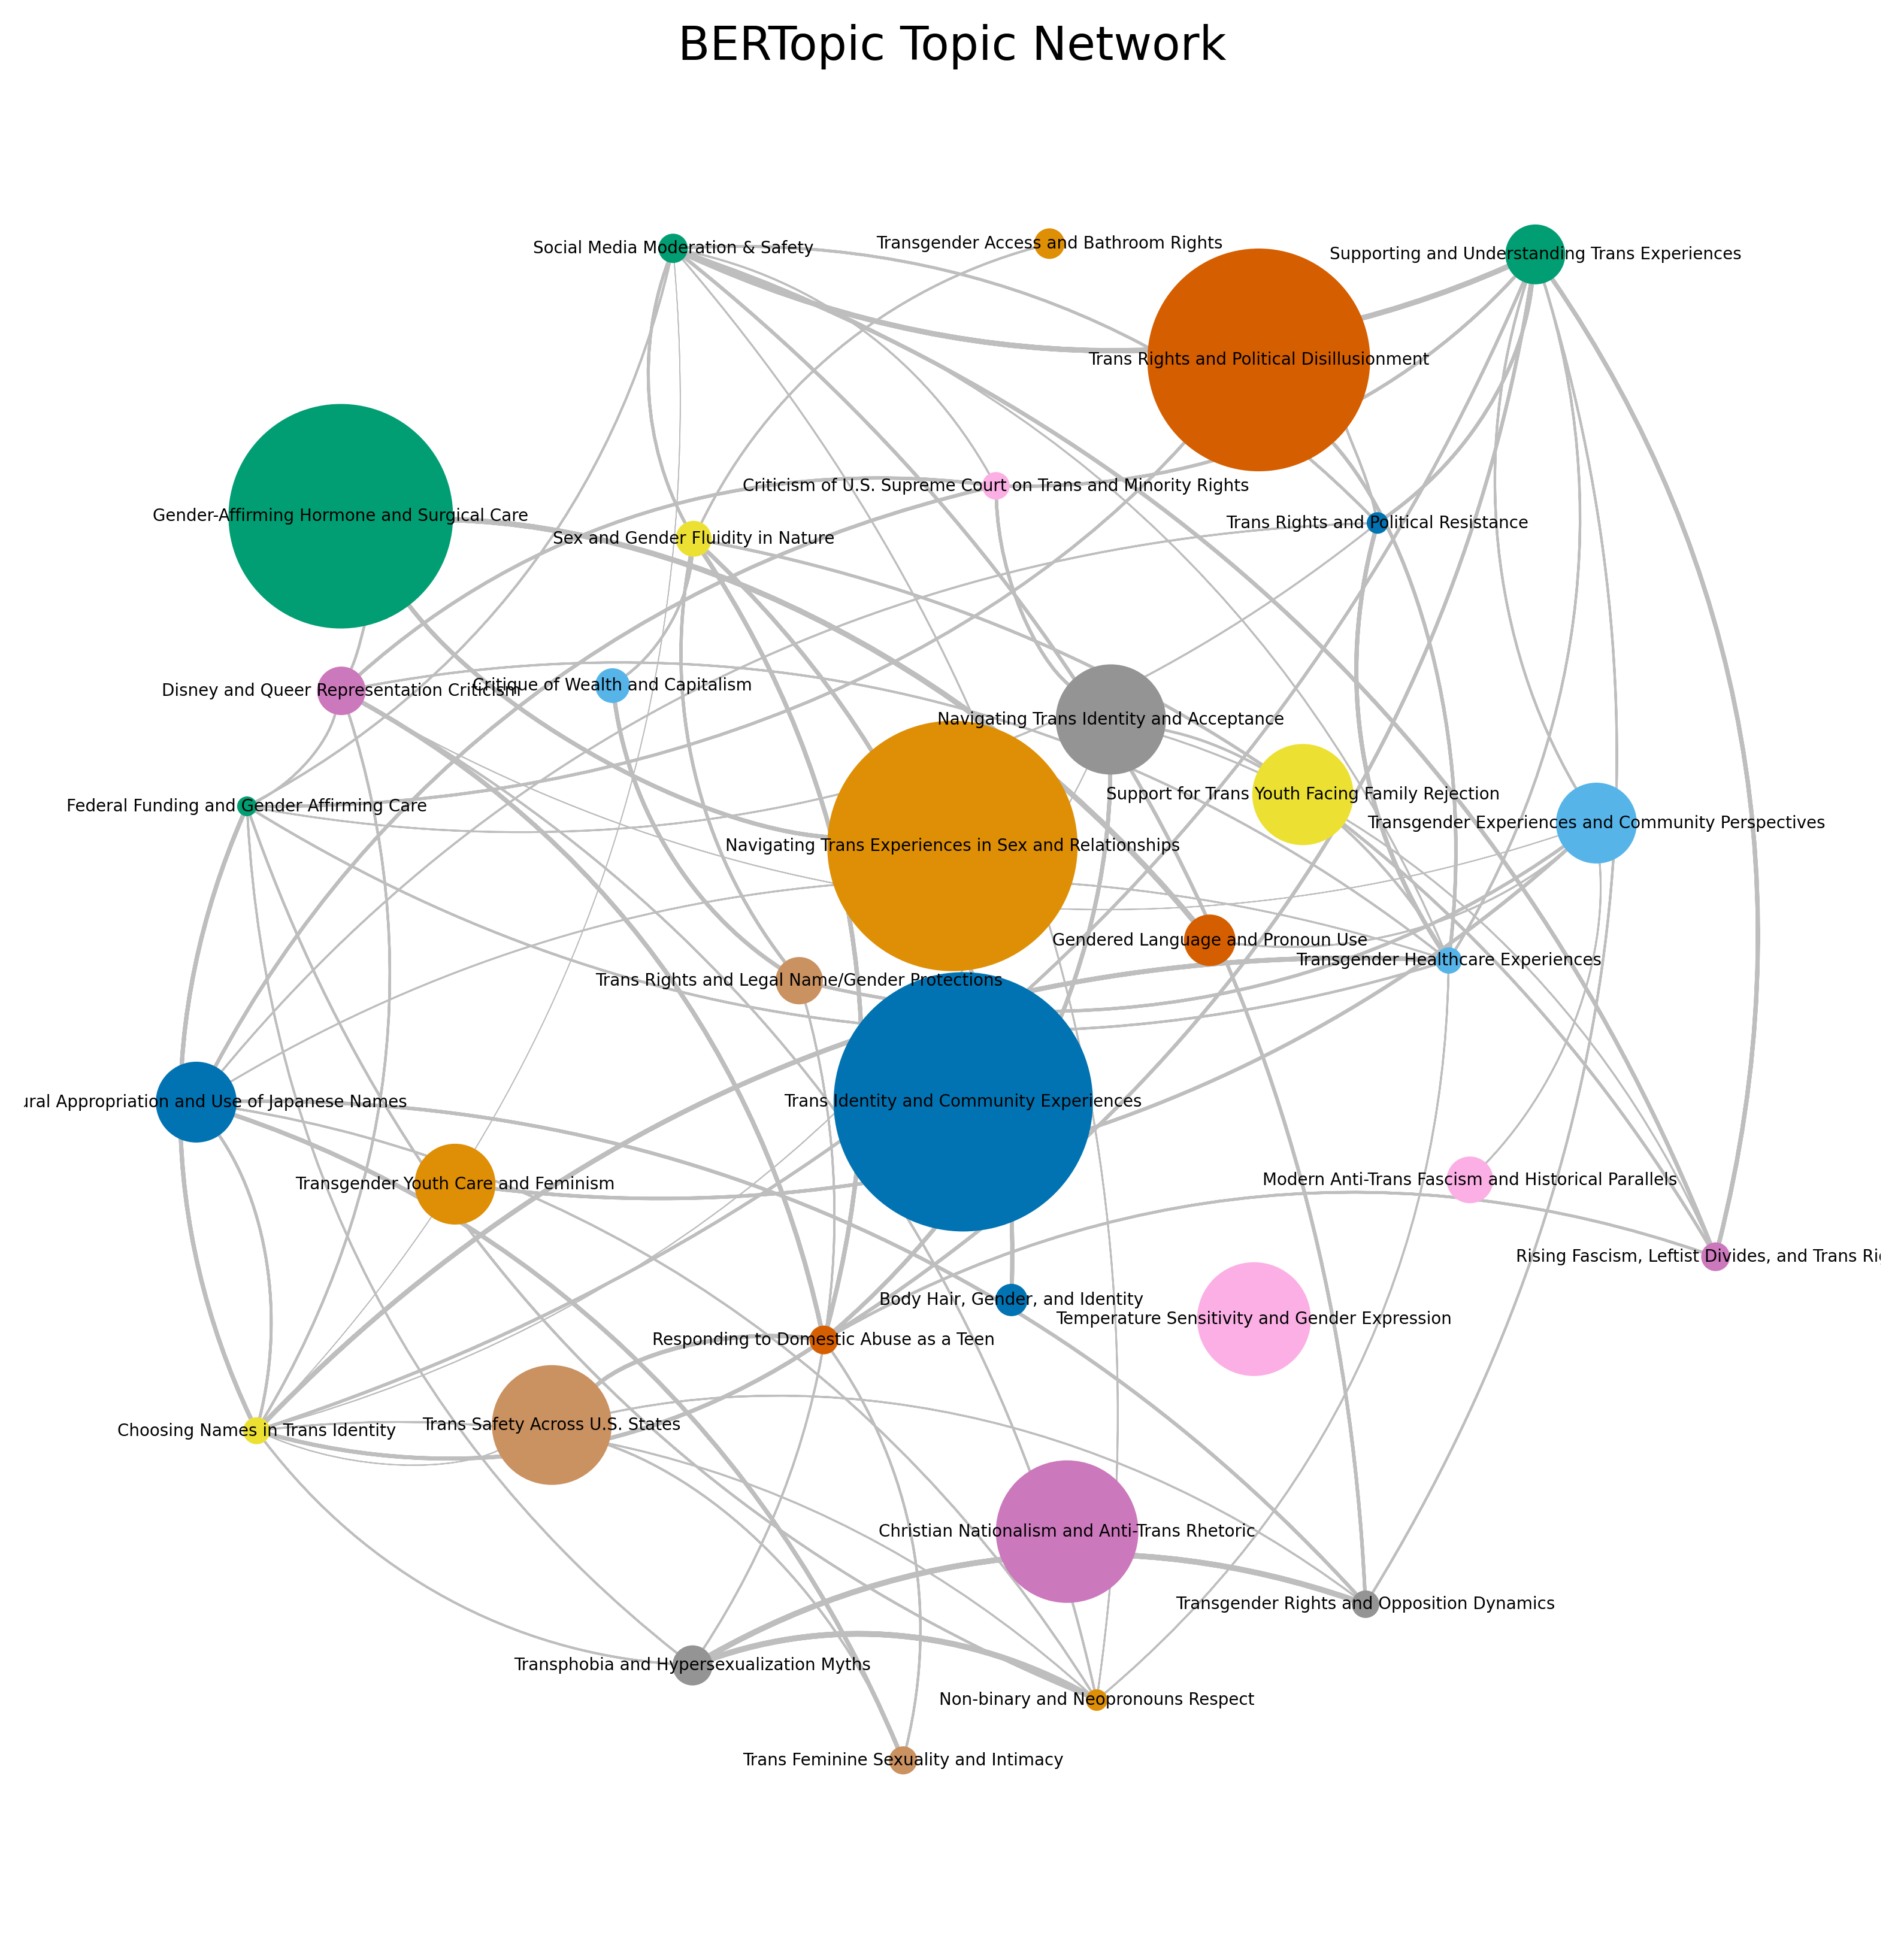

In [ ]:
# Plot topic dependencies
t.plot_topic_network(bert_model, topic_labels_dict, title="BERTopic Topic Network")


### Topic Interpretation (Reduced)

In [34]:
# Topic info
reduced_model.get_topic_info()

Topic  Count                                   Name  \
0      -1     12          -1_rewphoria_summed_oop_batty   
1       0   1195               0_thank_post_thanks_read   
2       1   1624                  1_cis_women_trans_men   
3       2    858           2_estrogen_hrt_months_growth   
4       3   1080        3_democrats_vote_republicans_us   
5       4    481       4_christians_christian_god_jesus   
6       5    545               5_state_states_blue_safe   
7       6    434                   6_wear_dress_go_cold   
8       7   1550                  7_life_like_time_feel   
9       8    654               8_parents_mom_family_dad   
10      9   1231                 9_people_trans_hate_us   
11     10    279         10_japanese_name_white_culture   
12     11    448      11_puberty_kids_blockers_children   
13     12   1009              12_like_friend_tell_would   
14     13    294             13_neutral_bro_guys_gender   
15     14    169  14_disney_characters_character_better   
16     15    257            15_birth_change_name_marker   
17     16    194            16_genocide_jews_nazis_nazi   
18     17    211                17_porn_blahaj_seen_toy   
19     18    178             18_sex_animals_gender_fish   
20     19    247            19_money_small_power_number   
21     20    170                 20_hair_body_women_cis   
22     21    233            21_bathroom_room_womens_use   
23     22    170    22_twitter_bluesky_facebook_account   
24     23    308          23_police_report_assault_call   
25     24    140   24_fascist_fascists_fascism_liberals   
26     25    155              25_horny_orgasm_girl_like   
27     26    167              26_court_supreme_law_case   
28     27    417           27_us_community_people_trans   
29     28    179               28_name_mom_sister_would   
30     29    215           29_surgery_doctor_bottom_top   
31     30    270            30_rights_human_fight_civil   
32     31    129     31_pronouns_nonbinary_theythem_use   
33     32    316      32_care_federal_healthcare_gender   

                                       Representation  Representative_Docs  
0   [rewphoria, summed, oop, batty, dahmer, roy, v...                  NaN  
1   [thank, post, thanks, read, lol, happy, hope, ...                  NaN  
2   [cis, women, trans, men, woman, like, man, peo...                  NaN  
3   [estrogen, hrt, months, growth, progesterone, ...                  NaN  
4   [democrats, vote, republicans, us, party, trum...                  NaN  
5   [christians, christian, god, jesus, bible, rel...                  NaN  
6   [state, states, blue, safe, red, live, califor...                  NaN  
7   [wear, dress, go, cold, wearing, pants, funera...                  NaN  
8   [life, like, time, feel, would, get, years, th...                  NaN  
9   [parents, mom, family, dad, child, love, sorry...                  NaN  
10  [people, trans, hate, us, like, transphobic, t...                  NaN  
11  [japanese, name, white, culture, racism, cultu...                  NaN  
12  [puberty, kids, blockers, children, trans, chi...                  NaN  
13  [like, friend, tell, would, talk, want, know, ...                  NaN  
14  [neutral, bro, guys, gender, gendered, sis, co...                  NaN  
15  [disney, characters, character, better, pixar,...                  NaN  
16  [birth, change, name, marker, passport, gender...                  NaN  
17  [genocide, jews, nazis, nazi, jewish, holocaus...                  NaN  
18  [porn, blahaj, seen, toy, plushie, trans, sexu...                  NaN  
19  [sex, animals, gender, fish, male, female, spe...                  NaN  
20  [money, small, power, number, people, rich, us...                  NaN  
21  [hair, body, women, cis, removal, laser, dysph...                  NaN  
22  [bathroom, room, womens, use, mens, school, re...                  NaN  
23  [twitter, bluesky, facebook, account, reddit, ...                  NaN  
24  [police, 

#### Representative Documents

In [35]:
# Get representative documents indices for each topic
repr_docs_idx_bert_reduced = t.get_representative_topics(10, reduced_model, df_dd, 'clean_text', 'bertopic_topic_reduced', 'repr_doc_reduced_rank')

# Get top documents per topic (original non-preprocessed text)
repr_docs_text_bert_reduced = t.top_docs_per_topic(10, df_dd, 'og_text', 'bertopic_topic_reduced', 'repr_doc_reduced_rank')

#### Fine-tune with GPT [NO NEED TO RUN]

In [50]:
# Prepare dictionary for fine-tuned labels
topic_labels_reduced = {i: {} for i in range(-1, 33)}

Prompt ChatGPT (each topic requires a new chat) with:

Based on the following documents from the same topic, generate:
    1. A concise topic label (3–6 words).
    2. A short summary (1–2 sentences) describing the topic's content.

"Documnt 1: ... "
"Document 2: ... "
"Document 3: ... "
"Document 4: ... "
"Document 5: ... "
"Document ... "

In [ ]:
# Print top documents in a topic
topic_number = 32
t.print_top_docs(topic_number, repr_docs_text_bert_reduced)

In [ ]:
# Update topics with fine-tuned labels and summaries
topic_labels_reduced[topic_number]['gpt_label'] = "Federal Threats to Gender-Affirming Care"
topic_labels_reduced[topic_number]['gpt_summary'] = "The documents discuss emerging legislative efforts—primarily from federal Republicans—to restrict or eliminate access to gender-affirming healthcare by defunding it at the federal level, primarily through Medicaid and Medicare. While these actions stop short of outright bans, they threaten to make such care inaccessible to many, especially low-income and trans youth, while state protections and private workarounds may still offer limited support."

# Check correctness
print(f"Topic: {topic_number}")
topic_labels_reduced[topic_number]

##### Save Custom Topics

In [ ]:
# Save to JSON
# filename_bert_reduced_tuned_topics = RESULTS_MODELS_DIR / 'bert_reduced' / 'fine_tuned_topics_sorted.json'
# with open(filename_bert_reduced_tuned_topics, 'w') as file:
    # json.dump(topic_labels_reduced, file, indent=4)

##### Load Custom Topics

In [166]:
# Load JSON
filename_bert_reduced_tuned_topics = RESULTS_MODELS_DIR / 'bert_reduced' / 'fine_tuned_topics_sorted.json'
with open(filename_bert_reduced_tuned_topics, 'r') as f:
    data_reduced = json.load(f)

topic_labels_reduced = {int(k): v for k, v in data_reduced.items()}

# Get topic ID - GPT label mapping and assign as model.custom_labels_
topic_labels_reduced_dict = {i: topic_labels_reduced[i]['gpt_label'] for i in range(-1, 33)}
reduced_model.set_topic_labels(topic_labels_reduced_dict)

### Visualize Topics

## Metrics
Modularity (non-overlapping and overlapping), NMI, Ncut.

### BERTopic (Original)

In [ ]:
# similarity_matrix = cosine_similarity(embeddings)

# Build kNN graph
n_neighbors = 15
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(doc_embeddings)
distances, indices = knn.kneighbors(doc_embeddings)

edges = []
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        if i != neighbor:
            edges.append((i, neighbor))

# Create igraph graph
g = ig.Graph()
g.add_vertices(len(doc_embeddings))
g.add_edges(edges)

# Prepare membership vector from dataframe labels
membership = df_dd['bertopic_topic'].tolist()

# Convert labels to numeric community IDs
unique_labels = list(set(membership))
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
membership_numeric = [label_to_id[label] for label in membership]

# Calculate modularity for given partition
mod_score = g.modularity(membership_numeric)
print(f"Modularity of BERTopic partition: {mod_score:.4f}")


Modularity of BERTopic partition: 0.3784
Louvain found modularity: 0.6018
Leiden modularity: 0.1599


### BERTopic (Reduced)

## Clear Allocated Memory

In [2]:
# Run before exiting the program to clear memory
%reset -f
import gc
gc.collect()

0